## Prism Data

In [77]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

In [2]:
consdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-consDF.pqt') #shows delinquents and credit score
acctdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt') #displays accounts and balances
trxndf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt') #each transaction with category number and amounts
cat_map = pd.read_csv('/uss/hdsi-prismdata/q2-ucsd-cat-map.csv') #mapping for category numbers

### Week 3

In [3]:
initial_df = (
    acctdf
    .merge(consdf, on='prism_consumer_id', how='outer')
    .groupby(['prism_consumer_id'])
    .agg(
        balance=('balance', 'sum'),
        balance_date=('balance_date', 'max')
    )
    .reset_index()
).merge(trxndf,on='prism_consumer_id', how='outer')
initial_df

,prism_consumer_id,balance,balance_date,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,0,320.37,2021-08-31,136696,4.0,0.09,CREDIT,2021-03-19
1,0,320.37,2021-08-31,136697,4.0,0.05,CREDIT,2021-04-16
2,0,320.37,2021-08-31,136698,4.0,0.06,CREDIT,2021-05-21
3,0,320.37,2021-08-31,136699,4.0,0.04,CREDIT,2021-06-18
4,0,320.37,2021-08-31,136700,4.0,0.02,CREDIT,2021-07-16
...,...,...,...,...,...,...,...,...
6407824,9999,-9.02,2023-08-09,1522635,16.0,66.63,DEBIT,2023-08-08
6407825,9999,-9.02,2023-08-09,1522636,14.0,16.91,DEBIT,2023-08-08
6407826,9999,-9.02,2023-08-09,1522637,14.0,3.52,DEBIT,2023-08-08
6407827,9999,-9.02,2023-08-09,1522638,16.0,7.99,DEBIT,2023-08-08


In [4]:
initial_df['prism_consumer_id'].nunique()

15000

In [5]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
initial_df["category"] = initial_df["category"].replace(mapping)
monthly_summary=initial_df.copy()
monthly_summary['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
print(monthly_summary['prism_consumer_id'].nunique())
monthly_summary['posted_date'] = pd.to_datetime(monthly_summary['posted_date'])
print(monthly_summary['prism_consumer_id'].nunique())
print(monthly_summary['posted_date'].isna().sum())

monthly_summary = (
    monthly_summary
    .groupby(['prism_consumer_id', monthly_summary['posted_date'].dt.to_period('M')], dropna=False)
    .agg(
        starting_balance=('balance', 'first'),
        monthly_total=('balance', 'sum'),
        trxndf_count = ('balance', 'count')
    )
    .reset_index()
)
print(monthly_summary['prism_consumer_id'].nunique())
monthly_summary['posted_date'] = monthly_summary['posted_date'].dt.to_timestamp()
print(monthly_summary['prism_consumer_id'].nunique())

15000
15000
508
15000
15000


In [6]:
monthly_summary['prism_consumer_id'].nunique()

15000

In [7]:
monthly_summary = monthly_summary.merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id', how='left')

In [8]:
# ensure date type
monthly_summary["posted_date"] = pd.to_datetime(monthly_summary["posted_date"])

# sort properly
monthly_summary = monthly_summary.sort_values(["prism_consumer_id", "posted_date"])

# calculate running balance
monthly_summary["monthly_balance"] = (
    monthly_summary["starting_balance"]
    + monthly_summary.groupby("prism_consumer_id")["monthly_total"].cumsum()
)

In [9]:
del_df = monthly_summary[monthly_summary['DQ_TARGET'] == 1]
nondel_df = monthly_summary[monthly_summary['DQ_TARGET'] == 0]
ids_1 = del_df["prism_consumer_id"].unique()
ids_0 = del_df["prism_consumer_id"].unique()

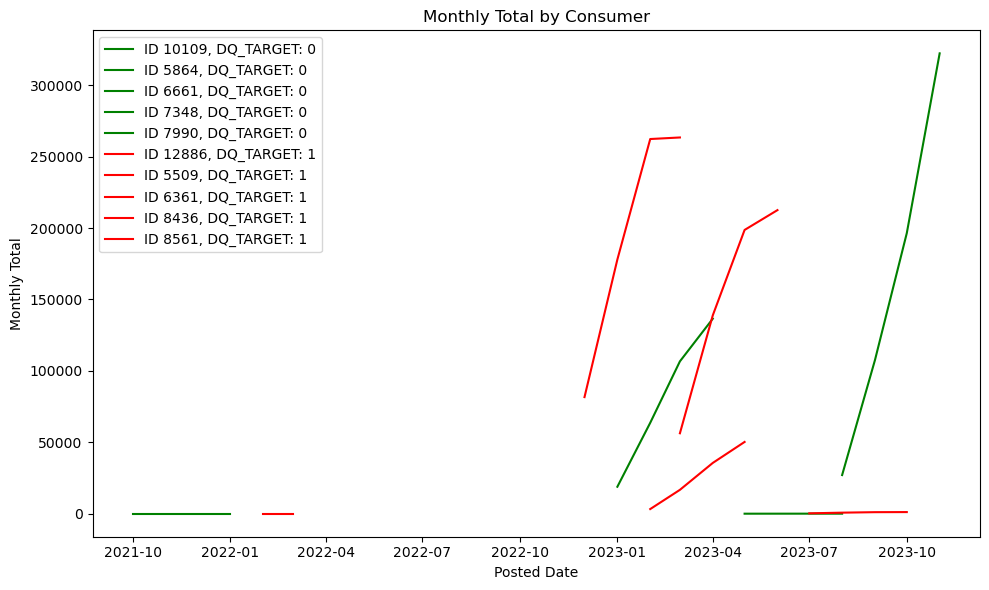

In [10]:
random.seed(10)

n=5

ids = np.random.choice(ids_0, size=n, replace=False)
ids2 = np.random.choice(ids_1,size=n,replace=False)

subset = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids)]
subset2 = monthly_summary[monthly_summary['prism_consumer_id'].isin(ids2)]

plt.figure(figsize=(10, 6))

for pid, df in subset.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 0',color='green')
    
for pid, df in subset2.groupby('prism_consumer_id'):
    plt.plot(df['posted_date'], df['monthly_balance'], label=f'ID {pid}, DQ_TARGET: 1',color='red')

plt.xlabel('Posted Date')
plt.ylabel('Monthly Total')
plt.title('Monthly Total by Consumer')
plt.legend()
plt.tight_layout()
plt.show()

### mtotal_df

In [11]:
mtotal_df = monthly_summary.groupby('prism_consumer_id').agg(
        DQ_TARGET = ('DQ_TARGET', 'first'),
        monthly_mean=('monthly_total', 'mean'),
        monthly_max=('monthly_total', 'max'),
        monthly_min=('monthly_total', 'min'),
        trxndf_count = ('trxndf_count','first'),
        month_count=('monthly_total', 'count')
    )

### cd_df

In [12]:
cd_df = initial_df[['prism_consumer_id','amount','credit_or_debit']].groupby(['prism_consumer_id','credit_or_debit'],dropna=False).sum().reset_index()

In [13]:
all_ids = cd_df['prism_consumer_id'].unique()

In [14]:
cd_df = (
    cd_df
    .pivot_table(
        index='prism_consumer_id',
        columns='credit_or_debit',
        values='amount',
        aggfunc='sum',
        fill_value=0
    )
    .assign(
        credit_debit_ratio=lambda x: x['CREDIT'] / (x['DEBIT'] + 1),
        net_flow=lambda x: x['CREDIT'] - x['DEBIT']
    )
).reindex(all_ids, fill_value=0)


In [15]:
cd_df = cd_df.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id', how='left')

In [16]:
net_df = initial_df[['prism_consumer_id','posted_date','category','credit_or_debit','amount']].copy()
net_df['amount'] = np.where(net_df['credit_or_debit'] == 'DEBIT', -net_df['amount'],net_df['amount'])
net_df['posted_date'] = pd.to_datetime(net_df['posted_date'])
net_df['month'] = net_df['posted_date'].dt.to_period('M')
mn_df = net_df.groupby(['prism_consumer_id','month'],dropna=False).agg(
        monthly_total=('amount', 'sum'),
        monthly_std =('amount','std')
    ).reset_index()

In [17]:
mn_df['prism_consumer_id'].nunique()

15000

### monthly_features

In [18]:
monthly_features = mn_df.groupby(['prism_consumer_id']).agg(
    monthly_net_total=('monthly_total', 'sum'),
    monthly_net_avg=('monthly_total', 'mean'),
    monthly_net_max=('monthly_total', 'max'),
    monthly_net_min=('monthly_total', 'min'),
    monthly_std_avg=('monthly_std', 'mean')
).reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id', how='left')
monthly_features['prism_consumer_id'] = monthly_features['prism_consumer_id'].astype(int)
mtotal_df = mtotal_df.reset_index()
mtotal_df['prism_consumer_id'] = mtotal_df['prism_consumer_id'].astype(int)
cd_df['prism_consumer_id'] = cd_df['prism_consumer_id'].astype(int)
monthly_features['net_range'] = monthly_features['monthly_net_max'] - monthly_features['monthly_net_min']

### catsum_df

In [19]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'],dropna=False)['amount'].sum().reset_index()

In [20]:
all_ids = cat_df['prism_consumer_id'].unique()
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount',
    )
    .fillna(0)
).reindex(all_ids, fill_value=0)


In [21]:
cat_pivot

category,NaN,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CORPORATE_PAYMENTS,...,REFUND,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.00,-540.00,-527.15,0.00,-1980.00,0.00,0.00,0.0,0.0,...,19.96,0.0,0.0,0.0,1.741030e+03,2603.52,0.0,-2.48,-108.75,0.0
1,0.0,0.00,-6999.13,-195.18,0.00,0.00,0.00,-251.43,0.0,0.0,...,2.42,0.0,0.0,0.0,0.000000e+00,2325.40,0.0,-51.80,0.00,0.0
10,0.0,0.00,-4112.00,-483.06,0.00,0.00,0.00,0.00,0.0,0.0,...,92.33,-103.0,0.0,0.0,-5.684342e-14,0.00,0.0,-35.04,0.00,0.0
100,0.0,0.00,-200.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,11.75,0.0,0.0,0.0,-4.202680e+03,0.00,0.0,0.00,0.00,0.0
1000,0.0,0.00,0.00,-204.03,0.00,0.00,0.00,0.00,0.0,0.0,...,1.37,0.0,0.0,0.0,-3.162727e+04,0.00,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.00,-1260.18,-115.56,-672.78,0.00,-53.98,-167.60,0.0,0.0,...,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,0.00,0.0
9996,0.0,0.00,0.00,-75.39,0.00,-184.34,0.00,0.00,0.0,0.0,...,0.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,-27.69,0.0
9997,0.0,-10.50,-1053.25,-217.60,-962.16,0.00,-230.00,-729.08,0.0,0.0,...,335.00,0.0,0.0,0.0,0.000000e+00,0.00,0.0,0.00,-136.34,0.0


In [22]:
outflows = cat_pivot.clip(upper=0).abs()
inflows  = cat_pivot.clip(lower=0)

cat_features = pd.DataFrame(index=cat_pivot.index)

cat_features['total_outflows'] = outflows.sum(axis=1)
cat_features['total_inflows']  = inflows.sum(axis=1)
cat_features['net_flow']       = cat_pivot.sum(axis=1)


In [23]:
for col in outflows.columns:
    cat_features[f'{col}_outflow_ratio'] = (
        outflows[col] / (cat_features['total_outflows'] + 1)
    )


In [24]:
# Income reliance
cat_features['paycheck_ratio'] = (
    inflows.get('PAYCHECK', 0) / (cat_features['total_inflows'] + 1)
)

# Cash usage
cat_features['atm_cash_ratio'] = (
    outflows.get('ATM_CASH', 0) / (cat_features['total_outflows'] + 1)
)

# Entertainment vs essentials proxy
cat_features['entertainment_ratio'] = (
    outflows.get('ENTERTAINMENT', 0) / (cat_features['total_outflows'] + 1)
)

# Refund dependence
cat_features['refund_ratio'] = (
    inflows.get('REFUND', 0) / (cat_features['total_inflows'] + 1)
)

In [25]:
outflows = outflows.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id', how='left')

In [26]:
cat_features = cat_features.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id', how='left')

In [27]:
add_df = cat_features[['prism_consumer_id','refund_ratio','paycheck_ratio']].copy()
add_df['prism_consumer_id'] = add_df['prism_consumer_id'].astype(int)
outflows['prism_consumer_id'] = outflows['prism_consumer_id'].astype(int)
out_df = outflows.copy()

In [28]:
out_df

,prism_consumer_id,NaN,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,...,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS,DQ_TARGET
0,0,0.0,0.00,540.00,527.15,0.00,1980.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,2.48,108.75,0.0,0.0
1,1,0.0,0.00,6999.13,195.18,0.00,0.00,0.00,251.43,0.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,51.80,0.00,0.0,0.0
2,10,0.0,0.00,4112.00,483.06,0.00,0.00,0.00,0.00,0.0,...,103.0,0.0,0.0,5.684342e-14,0.0,0.0,35.04,0.00,0.0,0.0
3,100,0.0,0.00,200.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,4.202680e+03,0.0,0.0,0.00,0.00,0.0,0.0
4,1000,0.0,0.00,0.00,204.03,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,3.162727e+04,0.0,0.0,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,9995,0.0,0.00,1260.18,115.56,672.78,0.00,53.98,167.60,0.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.00,0.00,0.0,NaN
14996,9996,0.0,0.00,0.00,75.39,0.00,184.34,0.00,0.00,0.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.00,27.69,0.0,NaN
14997,9997,0.0,10.50,1053.25,217.60,962.16,0.00,230.00,729.08,0.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.00,136.34,0.0,NaN
14998,9998,0.0,23.35,503.00,185.15,511.72,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,1.040000e+02,0.0,0.0,51.12,0.00,0.0,NaN


### catavg_df

In [29]:
initial_df['amount'] = np.where(initial_df['credit_or_debit'] == 'DEBIT', -initial_df['amount'],initial_df['amount'])
cat_df = initial_df.groupby(['prism_consumer_id','category'],dropna=False)['amount'].mean().reset_index()

In [30]:
all_ids = cat_df['prism_consumer_id'].unique()
cat_pivot = (
    cat_df
    .pivot(
        index='prism_consumer_id',
        columns='category',
        values='amount'
    )
    .fillna(0)
).reindex(all_ids, fill_value=0)
cat_pivot.columns = cat_pivot.columns + "_trxnavg"
cat_pivot = cat_pivot.reset_index().merge(consdf[['prism_consumer_id','DQ_TARGET']],on='prism_consumer_id', how='left')
cat_pivot['prism_consumer_id'] = cat_pivot['prism_consumer_id'].astype(int)

In [31]:
cat_pivot

,prism_consumer_id,NaN,ACCOUNT_FEES_trxnavg,ATM_CASH_trxnavg,AUTOMOTIVE_trxnavg,AUTO_LOAN_trxnavg,BANKING_CATCH_ALL_trxnavg,BILLS_UTILITIES_trxnavg,BNPL_trxnavg,CHILD_DEPENDENTS_trxnavg,...,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg,DQ_TARGET
0,0,0.0,0.000000,180.000000,25.102381,0.00,396.000,0.00,0.000000,0.0,...,0.0,0.0,0.0,116.685652,867.84,0.0,2.480000,54.375000,0.0,0.0
1,1,0.0,0.000000,199.975143,27.882857,0.00,0.000,0.00,17.959286,0.0,...,0.0,0.0,0.0,233.410256,1162.70,0.0,25.900000,0.000000,0.0,0.0
2,10,0.0,0.000000,228.444444,21.002609,0.00,0.000,0.00,0.000000,0.0,...,103.0,0.0,0.0,237.568750,0.00,0.0,17.520000,0.000000,0.0,0.0
3,100,0.0,0.000000,200.000000,0.000000,0.00,0.000,0.00,0.000000,0.0,...,0.0,0.0,0.0,547.296667,0.00,0.0,0.000000,0.000000,0.0,0.0
4,1000,0.0,0.000000,0.000000,34.005000,0.00,0.000,0.00,0.000000,0.0,...,0.0,0.0,0.0,828.920370,0.00,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,9995,0.0,0.000000,420.060000,23.112000,336.39,0.000,53.98,15.236364,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.0,NaN
14996,9996,0.0,0.000000,0.000000,18.847500,0.00,46.085,0.00,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,27.690000,0.0,NaN
14997,9997,0.0,5.250000,263.312500,27.200000,160.36,0.000,230.00,36.454000,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,45.446667,0.0,NaN
14998,9998,0.0,5.837500,167.666667,30.858333,511.72,0.000,0.00,0.000000,0.0,...,0.0,0.0,0.0,52.000000,0.00,0.0,51.120000,0.000000,0.0,NaN


### Income_Df

In [32]:
mapping = dict(zip(cat_map["category_id"], cat_map["category"]))
trxndf["category"] = trxndf["category"].replace(mapping)

income_categories = [
    'PAYCHECK',
    'DEPOSIT',
    'UNEMPLOYMENT_BENEFITS',
    'OTHER_BENEFITS',
    'PENSION',
    'INVESTMENT_INCOME'
]

income_df = trxndf[
    trxndf['category'].isin(income_categories)
].copy()
income_df['prism_transaction_id'].duplicated().sum()
income_df['posted_date'] = pd.to_datetime(income_df['posted_date'])

In [33]:
income_time = (
    income_df
    .groupby('prism_consumer_id')
    .agg(
        first_income_date=('posted_date', 'min'),
        last_income_date=('posted_date', 'max')
    )
    .reset_index()
)

income_time['income_span_days'] = (
    income_time['last_income_date'] - income_time['first_income_date']
).dt.days

In [34]:
income_df = income_time[['prism_consumer_id','income_span_days']]
income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)

/tmp/ipykernel_1873/1562562249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_df['prism_consumer_id'] = income_time['prism_consumer_id'].astype(int)


In [35]:
income_df

,prism_consumer_id,income_span_days
0,0,176
1,1,168
2,10,168
3,100,169
4,1000,177
...,...,...
13873,9995,77
13874,9996,61
13875,9997,84
13876,9998,71


### Try the counts of negative categories, look at external transfer as well

remove credit cards, loans, lines of credit

## Main model testing

In [36]:
cat_pivot= cat_pivot.drop(columns='DQ_TARGET')
cat_pivot

,prism_consumer_id,NaN,ACCOUNT_FEES_trxnavg,ATM_CASH_trxnavg,AUTOMOTIVE_trxnavg,AUTO_LOAN_trxnavg,BANKING_CATCH_ALL_trxnavg,BILLS_UTILITIES_trxnavg,BNPL_trxnavg,CHILD_DEPENDENTS_trxnavg,...,REFUND_trxnavg,RENT_trxnavg,RISK_CATCH_ALL_trxnavg,RTO_LTO_trxnavg,SELF_TRANSFER_trxnavg,TAX_trxnavg,TIME_OR_STUFF_trxnavg,TRANSPORATION_trxnavg,TRAVEL_trxnavg,UNEMPLOYMENT_BENEFITS_trxnavg
0,0,0.0,0.000000,180.000000,25.102381,0.00,396.000,0.00,0.000000,0.0,...,19.96000,0.0,0.0,0.0,116.685652,867.84,0.0,2.480000,54.375000,0.0
1,1,0.0,0.000000,199.975143,27.882857,0.00,0.000,0.00,17.959286,0.0,...,2.42000,0.0,0.0,0.0,233.410256,1162.70,0.0,25.900000,0.000000,0.0
2,10,0.0,0.000000,228.444444,21.002609,0.00,0.000,0.00,0.000000,0.0,...,18.46600,103.0,0.0,0.0,237.568750,0.00,0.0,17.520000,0.000000,0.0
3,100,0.0,0.000000,200.000000,0.000000,0.00,0.000,0.00,0.000000,0.0,...,1.46875,0.0,0.0,0.0,547.296667,0.00,0.0,0.000000,0.000000,0.0
4,1000,0.0,0.000000,0.000000,34.005000,0.00,0.000,0.00,0.000000,0.0,...,1.37000,0.0,0.0,0.0,828.920370,0.00,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,9995,0.0,0.000000,420.060000,23.112000,336.39,0.000,53.98,15.236364,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.0
14996,9996,0.0,0.000000,0.000000,18.847500,0.00,46.085,0.00,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,27.690000,0.0
14997,9997,0.0,5.250000,263.312500,27.200000,160.36,0.000,230.00,36.454000,0.0,...,16.75000,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,45.446667,0.0
14998,9998,0.0,5.837500,167.666667,30.858333,511.72,0.000,0.00,0.000000,0.0,...,116.07875,0.0,0.0,0.0,52.000000,0.00,0.0,51.120000,0.000000,0.0


In [37]:
mtotal_df

,prism_consumer_id,DQ_TARGET,monthly_mean,monthly_max,monthly_min,trxndf_count,month_count
0,0,0.0,18672.994286,27231.45,8970.36,33,7
1,1,0.0,148137.125714,208052.46,102375.02,31,7
2,10,0.0,40152.262857,60169.52,19781.76,31,7
3,100,0.0,53994.556667,63731.28,45142.99,19,6
4,1000,0.0,2871.107143,3524.25,476.25,5,7
...,...,...,...,...,...,...,...
14995,9995,NaN,0.000000,0.00,0.00,78,4
14996,9996,NaN,2653.035000,4295.39,1010.68,5,4
14997,9997,NaN,39886.020000,62961.84,9780.48,16,4
14998,9998,NaN,-63285.933333,-50053.42,-75080.13,75,3


In [38]:
main_df= monthly_features.merge(mtotal_df,on='prism_consumer_id',how='left')
print(len(main_df))
main_df['DQ_TARGET'] = main_df['DQ_TARGET_x']
main_df = main_df.drop(columns=['DQ_TARGET_x','DQ_TARGET_y'])
cd_df = cd_df.drop(columns=['net_flow','DQ_TARGET'])
print(len(main_df))
main_df= main_df.merge(cd_df,on='prism_consumer_id',how='left')
print(len(main_df))
main_df= main_df.merge(add_df,on='prism_consumer_id',how='left')
print(len(main_df))
main_df= main_df.merge(out_df,on='prism_consumer_id',how='left')
print(len(main_df))
main_df= main_df.merge(income_df,on='prism_consumer_id',how='left')
print(len(main_df))
main_df= main_df.merge(cat_pivot,on='prism_consumer_id',how='left')

15000
15000
15000
15000
15000
15000


# Heidi

In [39]:
# columns I will need: credit/debit, amount, posted date, evaluation date, prism consumer id, DQ_TARGET
merged = pd.merge(consdf, trxndf, on='prism_consumer_id', how='left')

In [40]:
merged = merged[merged['posted_date'] <= merged['evaluation_date']]
credit_only = merged[merged['credit_or_debit'] == 'CREDIT'].copy()
credit_only['posted_date'] = pd.to_datetime(credit_only['posted_date'])
credit_only['Year-Month'] = credit_only['posted_date'].dt.to_period('M')
debt_only = trxndf[trxndf['credit_or_debit']=='DEBIT']
monthly_inflow = credit_only.groupby(['prism_consumer_id', 'Year-Month'])['amount'].sum().reset_index(name='monthly_inflow')
consdf['Evaluation Month'] = consdf['evaluation_date'].dt.to_period('M')
with_eval_month = pd.merge(consdf, monthly_inflow, on='prism_consumer_id', how='left')

In [41]:
with_eval_month['months_diff'] = (
    (with_eval_month['Evaluation Month'].dt.year - with_eval_month['Year-Month'].dt.year) * 12 +
    (with_eval_month['Evaluation Month'].dt.month - with_eval_month['Year-Month'].dt.month)
)
last_year = with_eval_month[(with_eval_month['months_diff'] >= 1) & (with_eval_month['months_diff'] <= 12)]
sum_yearly_inflow = last_year.groupby('prism_consumer_id')['monthly_inflow'].sum().reset_index(name='avg_yearly_inflow')
year_std = last_year.groupby('prism_consumer_id')['monthly_inflow'].std().reset_index()
year_std.columns = ['prism_consumer_id', 'std_inflow']

In [42]:
# Trend: Is income increasing or decreasing?
def calculate_trend(group):
    if len(group) < 2:
        return 0
    months = group['months_diff'].values
    inflows = group['monthly_inflow'].values
    return np.polyfit(months, inflows, 1)[0]  # slope

trend = last_year.groupby('prism_consumer_id').apply(calculate_trend, include_groups=False).reset_index()
trend.columns = ['prism_consumer_id', 'trend']
num_transactions = last_year.groupby('prism_consumer_id').size().reset_index()
num_transactions.columns = ['prism_consumer_id', 'num_transactions']

In [43]:
debt_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT'].copy()
debt_only['posted_date'] = pd.to_datetime(debt_only['posted_date'])
# debt_only['category'] = debt_only['category'].astype(int)

# debt_with_category = pd.merge(debt_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id',\
#     'prism_transaction_id', 'amount', 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
debt_with_category = debt_only.rename(columns={'category_y':'category'})
groceries_only = debt_with_category[debt_with_category['category']=='GROCERIES']

debt_with_eval = pd.merge(groceries_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 3 months before evaluation_date
debt_with_eval['months_before_eval'] = (
    (debt_with_eval['evaluation_date'].dt.year - debt_with_eval['posted_date'].dt.year) * 12 +
    (debt_with_eval['evaluation_date'].dt.month - debt_with_eval['posted_date'].dt.month)
)

debt_9m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & 
                          (debt_with_eval['months_before_eval'] < 9)]

# total spend of groceries per consumer over a 9 month window (last 9 months before eval date)
total_spend_groceries_9m = debt_9m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_groceries_9m.columns = ['prism_consumer_id', 'sum_groceries_9m']

In [44]:
# total spend of dining per consumer over a month window (last month before eval date)
dining_only = debt_with_category[debt_with_category['category']=='FOOD_AND_BEVERAGES']

debt_with_eval_dining = pd.merge(dining_only, consdf[['prism_consumer_id', 'evaluation_date']], on='prism_consumer_id', how='left')

# Filter for transactions in the 6 months before evaluation_date
debt_with_eval_dining['months_before_eval'] = (
    (debt_with_eval_dining['evaluation_date'].dt.year - debt_with_eval_dining['posted_date'].dt.year) * 12 +
    (debt_with_eval_dining['evaluation_date'].dt.month - debt_with_eval_dining['posted_date'].dt.month)
)

debt_6m = debt_with_eval_dining[(debt_with_eval_dining['months_before_eval'] >= 0) & 
                          (debt_with_eval_dining['months_before_eval'] < 6)]

# total spend of groceries per consumer over a 6 month window (last 6 months before eval date)
total_spend_dining_6m = debt_6m.groupby('prism_consumer_id')['amount'].sum().reset_index()
total_spend_dining_6m.columns = ['prism_consumer_id', 'sum_dining_6m']

In [45]:
# merge evaluation date ONCE
tx = debt_with_category.merge(
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

tx = tx[tx['credit_or_debit'] == 'DEBIT']
tx['amount'] = tx['amount'].abs()

# numerator
total_spend_gambling = tx[tx['category'] == 'GAMBLING'].groupby('prism_consumer_id')['amount'].sum()

# denominator
total_spend_all = tx.groupby('prism_consumer_id')['amount'].sum()

pct_spend_gambling = (total_spend_gambling / total_spend_all).fillna(0).reset_index(name='pct_spend_gambling')


In [46]:
essentials = ['RENT', 'MORTGAGE', 'BILLS_UTILITIES', 'ESSENTIAL_SERVICES', 'GROCERIES', 'AUTOMOTIVE', 'TRANSPORTATION', \
'HEALTHCARE_MEDICAL', 'INSURANCE', 'CHILD_DEPENDENTS', 'PETS', 'TAX', 'LOAN', 'AUTO_LOAN', 'DEBT', 'CREDIT_CARD_PAYMENT', \
'EDUCATION', 'LEGAL', 'GOVERNMENT_SERVICES']

total_spend_essentials = tx[tx['category'].isin(essentials)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_essentials = (total_spend_essentials / total_spend_all).reset_index()

pct_spend_essentials = pct_spend_essentials.rename(columns={'amount':'pct_spend_essentials'})

In [47]:
# # change in groceries per consumer from the 3 most recent months to the prior 3-6 months before evaluation date
# lowers AUC from 0.721 to 0.71

# recent 3 months (0–2)
recent_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 0) & (debt_with_eval['months_before_eval'] < 3)]

recent_spend = recent_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_0_3m')

# prior 3 months (3–5)
prior_3m = debt_with_eval[(debt_with_eval['months_before_eval'] >= 3) & (debt_with_eval['months_before_eval'] < 6)]

prior_spend = prior_3m.groupby('prism_consumer_id')['amount'].sum().reset_index(name='groceries_3_6m')

# merge and compute delta
delta_groceries_3m = recent_spend.merge(
    prior_spend,
    on='prism_consumer_id',
    how='outer'
).fillna(0)

delta_groceries_3m['delta_groceries_3m'] = delta_groceries_3m['groceries_0_3m'] - delta_groceries_3m['groceries_3_6m']

delta_groceries_3m = delta_groceries_3m[['prism_consumer_id', 'delta_groceries_3m']]

utilities = ['BILLS_UTILITIES', 'ESSENTIAL_SERVICES']

total_spend_utilities = tx[tx['category'].isin(utilities)].groupby('prism_consumer_id')['amount'].sum()

pct_spend_utilities = (total_spend_utilities / total_spend_all).reset_index()

pct_spend_utilities = pct_spend_utilities.rename(columns={'amount':'pct_spend_utilities'})

In [48]:
# has overdraft - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for OVERDRAFT category AND within 6 months
overdraft_6m = debt_with_eval[
    (debt_with_eval['category'] == 'OVERDRAFT') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with overdrafts
has_overdraft_6m = overdraft_6m.groupby('prism_consumer_id').size().reset_index(name='overdraft_count')
has_overdraft_6m['has_overdraft_6m'] = 1

has_overdraft_6m = has_overdraft_6m[['prism_consumer_id', 'has_overdraft_6m']]

In [49]:
# has account fees - 6 months
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

# Filter for ACCOUNT FEES category AND within 6 months
acct_fees_6m = debt_with_eval[
    (debt_with_eval['category'] == 'ACCOUNT_FEES') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_acct_fee_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='acct_fees_count')
has_acct_fee_6m['has_acct_fee_6m'] = 1

has_acct_fee_6m = has_acct_fee_6m[['prism_consumer_id', 'has_acct_fee_6m']]

In [50]:
#atm cash ratio per consumer

debt_with_eval = pd.merge(
    debt_with_category,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debt_with_eval['posted_date'] = pd.to_datetime(debt_with_eval['posted_date'])
debt_with_eval['evaluation_date'] = pd.to_datetime(debt_with_eval['evaluation_date'])

debt_with_eval = debt_with_eval[
    debt_with_eval['posted_date'] <= debt_with_eval['evaluation_date']
]

total_debt_spend = debt_with_eval.groupby('prism_consumer_id')['amount'].sum().reset_index(name='total_debit_spend')

In [51]:
atm_cash_spend = (
    debt_with_eval[debt_with_eval['category'] == 'ATM_CASH']
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='atm_cash_spend')
)

atm_cash_ratio = total_debt_spend.merge(atm_cash_spend, on='prism_consumer_id',how='left').fillna(0)
atm_cash_ratio['atm_cash_ratio'] = atm_cash_ratio['atm_cash_spend'] / atm_cash_ratio['total_debit_spend']
atm_cash_ratio['atm_cash_ratio'] = (
    atm_cash_ratio['atm_cash_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)

In [52]:
# Merge evaluation dates with ALL debt transactions
debt_with_eval = pd.merge(
    debt_with_category, 
    consdf[['prism_consumer_id', 'evaluation_date']], 
    on='prism_consumer_id', 
    how='left'
)

# Calculate days before evaluation
debt_with_eval['days_before_eval'] = (
    debt_with_eval['evaluation_date'] - debt_with_eval['posted_date']
).dt.days

atm_cash_freq_6m = acct_fees_6m.groupby('prism_consumer_id').size().reset_index(name='atm_cash_freq_6m')

In [53]:
# refund ratio
credit_only = trxndf[trxndf['credit_or_debit']=='CREDIT']
# merged_credit = pd.merge(credit_only, cat_map, left_on='category', right_on='category_id', how='left')[['prism_consumer_id', 'prism_transaction_id', 'amount', \
# 'credit_or_debit', 'posted_date', 'category_id', 'category_y']]
merged_credit = credit_only.rename(columns={'category_y': 'category'})

credit_with_eval = pd.merge(
    merged_credit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

credit_with_eval['posted_date'] = pd.to_datetime(credit_with_eval['posted_date'])
credit_with_eval['evaluation_date'] = pd.to_datetime(credit_with_eval['evaluation_date'])

credit_with_eval['days_before_eval'] = (credit_with_eval['evaluation_date'] - credit_with_eval['posted_date']).dt.days
window = credit_with_eval[(credit_with_eval['days_before_eval'] >= 0) & (credit_with_eval['days_before_eval'] <= 180)]

refund = window[window['category']=='REFUND'].groupby('prism_consumer_id')['amount'].sum().reset_index(name='refund_amount')

In [54]:
debit_only = trxndf[trxndf['credit_or_debit'] == 'DEBIT']
# merged_debit = pd.merge(
#     debit_only,
#     cat_map,
#     left_on='category',
#     right_on='category_id',
#     how='left'
# )[[
#     'prism_consumer_id',
#     'prism_transaction_id',
#     'amount',
#     'credit_or_debit',
#     'posted_date',
#     'category_id',
#     'category_y'
# ]]

merged_debit = debit_only.rename(columns={'category_y': 'category'})
debit_with_eval = pd.merge(
    merged_debit,
    consdf[['prism_consumer_id', 'evaluation_date']],
    on='prism_consumer_id',
    how='left'
)

debit_with_eval['posted_date'] = pd.to_datetime(debit_with_eval['posted_date'])
debit_with_eval['evaluation_date'] = pd.to_datetime(debit_with_eval['evaluation_date'])

debit_with_eval['days_before_eval'] = (
    debit_with_eval['evaluation_date'] - debit_with_eval['posted_date']
).dt.days

debit_window = debit_with_eval[
    (debit_with_eval['days_before_eval'] >= 0) &
    (debit_with_eval['days_before_eval'] <= 180)
]

debit_spend = debit_window[
    debit_window['category'] != 'REFUND'
]
denominator = (
    debit_spend
    .groupby('prism_consumer_id')['amount']
    .sum()
    .reset_index(name='total_debit_spend')
)

In [55]:
refund_ratio = denominator.merge(
    refund,
    on='prism_consumer_id',
    how='left'
).fillna(0)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_amount'] /
    refund_ratio['total_debit_spend']
)

refund_ratio['refund_ratio'] = (
    refund_ratio['refund_ratio']
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)
refund_ratio = refund_ratio[['prism_consumer_id', 'refund_ratio']]

In [56]:
# debt_payment_ratio
# (LOAN + CREDIT_CARD_PAYMENT + AUTO_LOAN + BNPL) / total_debit_spend
categories_of_interest = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

summary = (
    debit_with_eval
    .groupby('prism_consumer_id')
    .agg(
        total_debit_spend=('amount', 'sum'),
        debt_spend=('amount', lambda x: x[
            debit_with_eval.loc[x.index, 'category'].isin(categories_of_interest)
        ].sum())
    )
    .reset_index()
)

summary['debt_spend_ratio'] = summary['debt_spend'] / summary['total_debit_spend']

In [57]:
# bnpl usage flag
# Filter for BNPL category AND within 6 months
bnpl_usage_6m = debt_with_eval[
    (debt_with_eval['category'] == 'BNPL') &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
has_bnpl_usage_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='bnpl_usage_flag')
has_bnpl_usage_6m['bnpl_usage_flag'] = 1

has_bnpl_usage_6m = has_bnpl_usage_6m[['prism_consumer_id', 'bnpl_usage_flag']]

In [58]:
debt_categories = ['LOAN', 'CREDIT_CARD_PAYMENT', 'AUTO_LOAN', 'BNPL']

debt_category_count = (
    debit_with_eval[debit_with_eval['category'].isin(debt_categories)]
    .groupby(['prism_consumer_id', 'category'])['amount']
    .sum()
    .reset_index()
)

# keep only categories with non-zero spend
debt_category_count = debt_category_count[debt_category_count['amount'] != 0]

debt_category_count = (
    debt_category_count
    .groupby('prism_consumer_id')
    .size()
    .reset_index(name='debt_category_count')
)

In [59]:
# discretionary drop flag
discretionary_cat_map = ['ENTERTAINMENT', 'TRAVEL', 'FITNESS']
df = debit_with_eval.copy()
df['month'] = df['posted_date'].dt.to_period('M')
monthly_disc = df[df['category'].isin(discretionary_cat_map)].groupby(['prism_consumer_id', 'month'])['amount'].sum().reset_index()

In [60]:
monthly_disc = monthly_disc.sort_values(['prism_consumer_id', 'month'])
monthly_disc['disc_3m_spend'] = monthly_disc.groupby('prism_consumer_id')['amount'].rolling(3, min_periods=3).sum().reset_index(drop=True)
monthly_disc['prev_disc_3m_spend'] = (
    monthly_disc
    .groupby('prism_consumer_id')['disc_3m_spend']
    .shift(3)
)

In [61]:
DROP_THRESHOLD = 0.30

monthly_disc['discretionary_drop_flag_3m'] = (
    (monthly_disc['prev_disc_3m_spend'] > 0) &
    ((monthly_disc['prev_disc_3m_spend'] - monthly_disc['disc_3m_spend'])
     / monthly_disc['prev_disc_3m_spend'] >= DROP_THRESHOLD)
).astype(int)

discretionary_drop_flag_3m = (
    monthly_disc
    .dropna(subset=['discretionary_drop_flag_3m'])
    .groupby('prism_consumer_id')
    .tail(1)
    [['prism_consumer_id', 'discretionary_drop_flag_3m']]
)

In [62]:
# essential spend volatility in 6 months
# Filter for essentials AND within 6 months
essential_spend_volatility_6m = debt_with_eval[
    (debt_with_eval['category'].isin(essentials)) &
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with acct fee
essential_spend_volatility_6m = essential_spend_volatility_6m.groupby('prism_consumer_id')['amount'].std().reset_index(name='essential_spend_volatility_6m')

essential_spend_volatility_6m = essential_spend_volatility_6m[['prism_consumer_id', 'essential_spend_volatility_6m']]

In [63]:
# child dependents spend sum in 6 months
# Filter for child dependents AND within 6 months
child_dependents_6m = debt_with_eval[
    (debt_with_eval['category']=='CHILD_DEPENDENTS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_child_deps_6m = bnpl_usage_6m.groupby('prism_consumer_id').size().reset_index(name='child_dependents_6m')
has_child_deps_6m['child_dependents_6m'] = 1

In [64]:
# child dependents spend sum in 6 months
# Filter for essentials AND within 6 months
pets_6m = debt_with_eval[
    (debt_with_eval['category']=='PETS')&
    (debt_with_eval['days_before_eval'] >= 0) & 
    (debt_with_eval['days_before_eval'] <= 180)
]

# Group to get consumers with child dependents
has_pets_6m = pets_6m.groupby('prism_consumer_id').size().reset_index(name='pets_6m')
has_pets_6m['pets_6m'] = 1

## Eval

In [65]:
df_eval = pd.merge(consdf, sum_yearly_inflow, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, year_std, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, trend, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, num_transactions, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_groceries_9m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, total_spend_dining_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_gambling, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, pct_spend_essentials, on='prism_consumer_id',how='left')
df_eval = pd.merge(df_eval, delta_groceries_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, pct_spend_utilities, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_overdraft_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_acct_fee_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, atm_cash_freq_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, refund_ratio, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, summary, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_bnpl_usage_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, debt_category_count, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, discretionary_drop_flag_3m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, essential_spend_volatility_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_child_deps_6m, on='prism_consumer_id', how='left')
df_eval = pd.merge(df_eval, has_pets_6m, on='prism_consumer_id', how='left')
df_eval['has_overdraft_6m'] = df_eval['has_overdraft_6m'].fillna(0).astype(int)
df_eval['has_acct_fee_6m'] = df_eval['has_acct_fee_6m'].fillna(0).astype(int)
df_eval['atm_cash_freq_6m'] = df_eval['atm_cash_freq_6m'].fillna(0).astype(int)
df_eval['bnpl_usage_flag'] = df_eval['bnpl_usage_flag'].fillna(0).astype(int)
df_eval['debt_category_count'] = df_eval['debt_category_count'].fillna(0).astype(int)
df_eval['child_dependents_6m'] = df_eval['child_dependents_6m'].fillna(0).astype(int)
df_eval['pets_6m'] = df_eval['pets_6m'].fillna(0).astype(int)
print(f"pre: {len(df_eval)}")

pre: 15000


In [66]:
df_eval['prism_consumer_id'] =df_eval['prism_consumer_id'].astype(int)
print(f"pre: {len(df_eval)}")
df_eval = main_df.merge(df_eval,on='prism_consumer_id', how='left')
print(f"pre: {len(df_eval)}")
print(f"pre: {len(main_df)}")

pre: 15000
pre: 15000
pre: 15000


In [67]:
print(f"pre: {len(df_eval)}")
period_cols = [col for col in df_eval.columns 
               if str(df_eval[col].dtype).startswith('period')]

datetime_cols = df_eval.select_dtypes(include=['datetime64[ns]', 'datetimetz']).columns

time_cols = list(datetime_cols) + period_cols
df_eval = df_eval.drop(columns=time_cols)
print(f"pre: {len(df_eval)}")

pre: 15000
pre: 15000


In [68]:
print(f"pre: {len(df_eval)}")
df_eval = df_eval.drop(columns=['DQ_TARGET_y','DQ_TARGET_x','credit_score'])
df_eval

pre: 15000


,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,refund_ratio_y,total_debit_spend_y,debt_spend,debt_spend_ratio,bnpl_usage_flag,debt_category_count,discretionary_drop_flag_3m,essential_spend_volatility_6m,child_dependents_6m,pets_6m
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,18672.994286,27231.45,8970.36,...,0.001456,14908.41,0.00,0.000000,0,0,1.0,30.759765,0,1
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,148137.125714,208052.46,102375.02,...,0.000122,23098.37,251.43,0.010885,1,1,0.0,24.447083,1,1
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,40152.262857,60169.52,19781.76,...,0.004769,21766.60,180.00,0.008270,0,1,0.0,41.262544,0,0
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,4609.53,53994.556667,63731.28,45142.99,...,NaN,39742.61,16188.17,0.407325,0,1,NaN,NaN,0,0
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,5867.23,2871.107143,3524.25,476.25,...,NaN,77914.99,17144.19,0.220037,0,2,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,9995,-121.55,-30.387500,42.05,-70.54,151.491880,112.59,0.000000,0.00,0.00,...,0.000000,17047.39,6465.94,0.379292,1,4,0.0,77.822752,1,0
14996,9996,9.14,2.285000,54.08,-57.36,104.316173,111.44,2653.035000,4295.39,1010.68,...,0.000000,1190.89,203.46,0.170847,0,1,0.0,38.577262,0,0
14997,9997,503.19,125.797500,1354.55,-1376.15,336.811717,2730.70,39886.020000,62961.84,9780.48,...,0.020056,16702.92,8150.24,0.487953,1,4,0.0,184.084410,1,0
14998,9998,-833.10,-277.700000,15.86,-771.74,273.190671,787.60,-63285.933333,-50053.42,-75080.13,...,0.060303,15399.47,6871.08,0.446189,0,2,0.0,119.164610,0,0


In [69]:
df_eval.dropna(subset=['DQ_TARGET'])

,prism_consumer_id,monthly_net_total,monthly_net_avg,monthly_net_max,monthly_net_min,monthly_std_avg,net_range,monthly_mean,monthly_max,monthly_min,...,refund_ratio_y,total_debit_spend_y,debt_spend,debt_spend_ratio,bnpl_usage_flag,debt_category_count,discretionary_drop_flag_3m,essential_spend_volatility_6m,child_dependents_6m,pets_6m
0,0,-521.59,-74.512857,830.73,-2584.24,213.544425,3414.97,1.867299e+04,27231.45,8970.36,...,0.001456,14908.41,0.00,0.000000,0,0,1.0,30.759765,0,1
1,1,1805.43,257.918571,1109.02,-940.73,292.763392,2049.75,1.481371e+05,208052.46,102375.02,...,0.000122,23098.37,251.43,0.010885,1,1,0.0,24.447083,1,1
2,10,-1190.04,-170.005714,431.40,-971.45,260.603079,1402.85,4.015226e+04,60169.52,19781.76,...,0.004769,21766.60,180.00,0.008270,0,1,0.0,41.262544,0,0
3,100,-4505.77,-750.961667,1276.72,-3332.81,832.186871,4609.53,5.399456e+04,63731.28,45142.99,...,NaN,39742.61,16188.17,0.407325,0,1,NaN,NaN,0,0
4,1000,438.08,62.582857,2982.67,-2884.56,1223.790895,5867.23,2.871107e+03,3524.25,476.25,...,NaN,77914.99,17144.19,0.220037,0,2,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14945,995,21842.68,3120.382857,10212.74,-3244.20,1016.422674,13456.94,2.053630e+06,3162590.31,670852.49,...,0.000292,31466.47,17430.79,0.553948,0,2,NaN,453.290338,0,0
14956,996,26713.18,3816.168571,41464.50,-16811.41,2623.765971,58275.91,0.000000e+00,0.00,0.00,...,0.000140,196249.61,19576.99,0.099756,0,2,0.0,718.424211,0,0
14967,997,-14899.66,-2128.522857,206.99,-3741.45,745.079512,3948.44,4.787867e+06,6756531.35,1404823.35,...,0.000606,81076.60,6121.09,0.075498,0,1,NaN,242.869263,0,0
14978,998,5507.73,786.818571,3359.83,-1022.35,537.836676,4382.18,7.987620e+05,1116887.94,275774.80,...,0.002461,66207.01,4039.81,0.061018,1,3,1.0,80.353375,1,0


In [70]:
X = df_eval.dropna(subset=['DQ_TARGET']).drop(columns=['prism_consumer_id','DQ_TARGET']).fillna(0)
y = df_eval['DQ_TARGET'].dropna()

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Logistic Regression

In [ ]:
print('Number of null values per feature')
X_train.isna().sum().sort_values(ascending=False).head(15)

In [ ]:
ratio_cols = [
    "pct_spend_utilities",
    "pct_spend_essentials",
    "refund_ratio_y",
    "atm_cash_ratio",
    "debt_spend_ratio",
    "pct_spend_gambling"
]
activity_cols = [
    "delta_groceries_3m",
    "sum_groceries_9m",
    "sum_dining_6m",
    "atm_cash_spend",
    "total_debit_spend_x",
    "total_debit_spend_y"
]
volatility_cols = [
    "essential_spend_volatility_6m",
    "std_inflow"
]
flag_cols = [
    "discretionary_drop_flag_3m"
]


In [ ]:
X_train_filled = X_train.copy()
X_test_filled  = X_test.copy()

zero_fill_cols = (
    ratio_cols +
    activity_cols +
    volatility_cols +
    flag_cols
)

for c in zero_fill_cols:
    if c in X_train_filled.columns:
        X_train_filled[c] = X_train_filled[c].fillna(0)
        X_test_filled[c]  = X_test_filled[c].fillna(0)

X_train_filled["debt_spend"] = X_train_filled["debt_spend"].fillna(0)
X_test_filled["debt_spend"]  = X_test_filled["debt_spend"].fillna(0)

In [ ]:
log_reg = LogisticRegression(max_iter=3000, solver="lbfgs")
log_reg.fit(X_train_filled, y_train)

y_test_prob = log_reg.predict_proba(X_test_filled)[:, 1]
print("Test AUC for Logistic Regression:", roc_auc_score(y_test, y_test_prob))


In [ ]:
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),     # safe fallback (even if no NaNs now)
    ("scaler", StandardScaler()),                      # key for convergence
    ("model", LogisticRegression(max_iter=10000, solver="lbfgs"))
])

pipe.fit(X_train_filled, y_train)

y_test_prob = pipe.predict_proba(X_test_filled)[:, 1]
print("Test AUC for Logistic Regression with a scaler and imputer:", roc_auc_score(y_test, y_test_prob))

In [ ]:
l1_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=20000,
        C=1.0,          # smaller C = more regularization
        n_jobs=-1
    ))
])

l1_pipe.fit(X_train_filled, y_train)

y_test_prob = l1_pipe.predict_proba(X_test_filled)[:, 1]
print("Test AUC (L1):", roc_auc_score(y_test, y_test_prob))

In [ ]:
coefs = pipe.named_steps["model"].coef_[0]
coef_df = (pd.DataFrame({
    "feature": X_train_filled.columns,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs)
}).sort_values("abs_coefficient", ascending=False))

coef_df


In [ ]:
for col in df_eval:
    print(col)

In [ ]:
# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)


rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=5
)


rfe.fit(X_train, y_train)

selected_50 = X_train.columns[rfe.support_].tolist()
ranking = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()

print("Selected 50:", selected_50[:10], "...")
print("Top ranked:\n", ranking.head(20))


In [ ]:
logit_full = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

logit_full.fit(X_train, y_train)

y_test_prob_full = logit_full.predict_proba(X_test)[:, 1]
auc_full = roc_auc_score(y_test, y_test_prob_full)

print("AUC (all features):", auc_full)


In [ ]:
X_train_50 = X_train[selected_50]
X_test_50  = X_test[selected_50]

logit_50 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

logit_50.fit(X_train_50, y_train)

y_test_prob_50 = logit_50.predict_proba(X_test_50)[:, 1]
auc_50 = roc_auc_score(y_test, y_test_prob_50)

print("AUC (top 50 features):", auc_50)
print(f"AUC change: {auc_50 - auc_full:+.4f}")


In [ ]:
X_train_50 = X_train[selected_50]
X_test_50  = X_test[selected_50]

xgb_model.fit(X_train_50, y_train)
y_test_prob = xgb_model.predict_proba(X_test_50)[:, 1]

print("AUC (top 50):", roc_auc_score(y_test, y_test_prob))

In [ ]:
for col in selected_50:
    print(col)

In [ ]:
# grouping observations into quantile bins
# computed observed deliquency rate per bin

def plot_binned_risk_5(
    df,
    feature,
    target="DQ_TARGET",
    n_bins=5
):
    tmp = df[[feature, target]].dropna().copy()

    # creates equal sized quantile bins
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = (
        tmp
        .groupby("bin")
        .agg(
            # risk rate is mean of target (aka adding alls DQ = 1 over total)
            # observed probability of delinquency
            risk_rate=(target, "mean"),
            # num in each bin
            count=(target, "size"),
            feature_mean=(feature, "mean")
        )
        .reset_index()
    )

    plt.figure(figsize=(7, 4))
    plt.plot(grouped["feature_mean"], grouped["risk_rate"], marker="o")
    plt.xlabel(feature)
    plt.ylabel("Observed Delinquency Rate")
    plt.title(f"Binned Risk Plot: {feature}")
    plt.grid(True)
    plt.show()

    return grouped

def plot_binned_risk_10(
    df,
    feature,
    target="DQ_TARGET",
    n_bins=10
):
    tmp = df[[feature, target]].dropna().copy()

    # creates equal sized quantile bins
    tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")

    grouped = (
        tmp
        .groupby("bin")
        .agg(
            # risk rate is mean of target (aka adding alls DQ = 1 over total)
            # observed probability of delinquency
            risk_rate=(target, "mean"),
            # num in each bin
            count=(target, "size"),
            feature_mean=(feature, "mean")
        )
        .reset_index()
    )

    plt.figure(figsize=(7, 4))
    plt.plot(grouped["feature_mean"], grouped["risk_rate"], marker="o")
    plt.xlabel(feature)
    plt.ylabel("Observed Delinquency Rate")
    plt.title(f"Binned Risk Plot: {feature}")
    plt.grid(True)
    plt.show()

    return grouped


In [ ]:
plot_binned_risk_5(df_eval, "avg_yearly_inflow")
plot_binned_risk_10(df_eval, "avg_yearly_inflow")

makes the most sense,  as average inflow increases, the deliquency rate decreases

In [ ]:
plot_binned_risk_5(df_eval, "total_debit_spend_x")
plot_binned_risk_10(df_eval, "total_debit_spend_x")

the plot shows that people who spend very little tend to have higher delinquency risk, while people who spend more overall tend to have lower risk. this is likely because higher spending reflects greater income and financial capacity, whereas very low spending may indicate financial stress or limited resources

In [ ]:
plot_binned_risk_5(df_eval, "essential_spend_volatility_6m")
plot_binned_risk_10(df_eval, "essential_spend_volatility_6m")

this plot shows that delinquency risk does not increase with higher volatility in essential spending. instead, risk is highest for consumers with low to moderate volatility and decreases sharply for those with very high volatility. while this may seem counterintuitive, high volatility likely reflects financial flexibility and higher income, whereas low volatility may indicate constrained budgets with limited ability to absorb shocks

In [ ]:
plot_binned_risk_5(df_eval, "monthly_net_min")
plot_binned_risk_10(df_eval, "monthly_net_min")


- `monthly_net_min` is the one's worst month financially (money in - money out)
- at first glance, this plot seems backwards because wouldn't the people that have less money than they made in a month be more unlikely to pay back a loan
- after looking at this plot, we can think people with negative months probably have a higher overall income, can move money around, can have high losses bc they know they can recover; those with net zero live very close to their limit, have little or no financial buffer, are more vulnerable to falling behind

In [ ]:
tmp = monthly_features[['prism_consumer_id', 'monthly_net_min', 'DQ_TARGET']].copy()

tmp['bin'] = pd.qcut(
    tmp['monthly_net_min'],
    q=10,
    duplicates='drop'
)
first_bin = tmp['bin'].cat.categories[0]
first_bin

In [ ]:
first_bin_consumers = tmp[tmp['bin'] == first_bin]
first_bin_consumers


In [ ]:
cols_to_inspect = [
    "prism_consumer_id",
    "monthly_net_min",
    "monthly_net_avg",
    "monthly_net_max",
    "monthly_net_total",
    "avg_yearly_inflow",
    "std_inflow",
    "num_transactions",
    "DQ_TARGET"
]

available_cols = [c for c in cols_to_inspect if c in df_eval.columns]

inspect_df = (
    first_bin_consumers[["prism_consumer_id"]]   # keep just the ids from the bin
    .merge(df_eval[available_cols], on="prism_consumer_id", how="left")
)

inspect_df.head()



In [ ]:
inspect_df.sort_values("monthly_net_min").head(10)


In [ ]:
trxndf[
    (trxndf['prism_consumer_id'] == '2267') &
    (trxndf['credit_or_debit'] == 'DEBIT')
].sort_values(['amount'], ascending = False)

In [ ]:
plot_binned_risk_10(df_eval, "has_overdraft_6m")


this feature is binary so this plot actually doesn't make sense 

In [ ]:
df_eval.groupby("has_overdraft_6m")["DQ_TARGET"].agg(
    risk_rate="mean",
    count="size"
)


consumers who had overdraft in the last 6 months are more than twice as likely to become delinquent compared to those who did not overdraft

### Random Forest

In [ ]:
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
print("ROC AUC for Random Forest:", roc_auc_score(y_test, y_prob))


In [ ]:
df_eval['DQ_TARGET'].dropna().value_counts()

In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC for XGBClassifier:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

In [ ]:
importance = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
print('Importance of each feature in the XGB model')
importance

### XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=xgb_model,
    n_features_to_select=50,
    step=1   # speed up elimination
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
xgb_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = xgb_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC using recursive feature selection and XGBoost:", auc_score)


In [ ]:
# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Random Forest Model ---
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,        # use all cores
    random_state=42
)

# --- RFE ---
rfe = RFE(
    estimator=rf_model,
    n_features_to_select=50,
    step=5   # step=1 = slow but precise, step=5 faster
)

rfe.fit(X_train, y_train)

# Selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", list(selected_features))

# Transform datasets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# --- Train final model on reduced features ---
rf_model.fit(X_train_rfe, y_train)

# --- Predict probabilities ---
y_probs = rf_model.predict_proba(X_test_rfe)[:, 1]

# --- AUC ---
auc_score = roc_auc_score(y_test, y_probs)
print("Test ROC-AUC using recursive feature selection and Random Forest:", auc_score)


In [ ]:
rf_full = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

rf_full.fit(X_train, y_train)
full_probs = rf_full.predict_proba(X_test)[:, 1]
full_auc = roc_auc_score(y_test, full_probs)

print("Random Forest Full Feature AUC:", full_auc)
print("Random Forest RFE Feature AUC:", auc_score)


# Final Model

In [71]:
print('Forward Selection on XGBoost Model to find the top 50 features for it')

Forward Selection on XGBoost Model to find the top 50 features for it


In [72]:
# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Forward Selection ---
selected_features = []
remaining_features = list(X.columns)
target_feature_count = 50

for i in range(target_feature_count):
    best_auc = 0
    best_feat = None
    
    for feat in remaining_features:
        current_feats = selected_features + [feat]
        
        model = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            random_state=42
        )
        model.fit(X_train[current_feats], y_train)
        
        y_probs = model.predict_proba(X_test[current_feats])[:, 1]
        auc = roc_auc_score(y_test, y_probs)
        
        if auc > best_auc:
            best_auc = auc
            best_feat = feat
    
    if best_feat is None:
        print("No improvement; stopping early.")
        break
    
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    print(f"Step {i+1}: Added feature '{best_feat}' with AUC={best_auc:.4f}")

# --- Final Selected Features ---
print("Top 50 Selected Features:", selected_features)

# --- Train Final XGBoost Model ---
final_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train[selected_features], y_train)

y_probs = final_model.predict_proba(X_test[selected_features])[:, 1]
final_auc = roc_auc_score(y_test, y_probs)
print("Final Test ROC-AUC:", final_auc)


Step 1: Added feature 'month_count' with AUC=0.7361
Step 2: Added feature 'monthly_max' with AUC=0.7754
Step 3: Added feature 'CREDIT_CARD_PAYMENT' with AUC=0.8036
Step 4: Added feature 'TRANSPORATION_trxnavg' with AUC=0.8100
Step 5: Added feature 'bnpl_usage_flag' with AUC=0.8195
Step 6: Added feature 'refund_ratio_y' with AUC=0.8206
Step 7: Added feature 'monthly_net_avg' with AUC=0.8264
Step 8: Added feature 'monthly_mean' with AUC=0.8226
Step 9: Added feature 'std_inflow' with AUC=0.8246
Step 10: Added feature 'OVERDRAFT_trxnavg' with AUC=0.8307
Step 11: Added feature 'pct_spend_essentials' with AUC=0.8294
Step 12: Added feature 'RENT' with AUC=0.8348
Step 13: Added feature 'FOOD_AND_BEVERAGES_trxnavg' with AUC=0.8341
Step 14: Added feature 'LOAN_trxnavg' with AUC=0.8345
Step 15: Added feature 'LOAN' with AUC=0.8383
Step 16: Added feature 'GAMBLING_trxnavg' with AUC=0.8405
Step 17: Added feature 'CREDIT' with AUC=0.8436
Step 18: Added feature 'FOOD_AND_BEVERAGES' with AUC=0.8447
St

/home/dtsukamoto/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:31:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test ROC-AUC: 0.8349147848750789


In [76]:
selected_features=['month_count', 'monthly_max', 'CREDIT_CARD_PAYMENT', 'TRANSPORATION_trxnavg', 'bnpl_usage_flag', 'refund_ratio_y', 'monthly_net_avg', 'monthly_mean', 'std_inflow', 'OVERDRAFT_trxnavg', 'pct_spend_essentials', 'RENT', 'FOOD_AND_BEVERAGES_trxnavg', 'LOAN_trxnavg', 'LOAN', 'GAMBLING_trxnavg', 'CREDIT', 'FOOD_AND_BEVERAGES', 'refund_ratio_x', 'OTHER_BENEFITS_trxnavg', 'MISCELLANEOUS', 'INSURANCE_trxnavg', 'GROCERIES_trxnavg', 'EXTERNAL_TRANSFER', 'RISK_CATCH_ALL_trxnavg', 'EXTERNAL_TRANSFER_trxnavg', 'discretionary_drop_flag_3m', 'EDUCATION', 'PETS_trxnavg', 'total_debit_spend_x', 'TRANSPORATION', 'atm_cash_spend', 'DEBT', 'SELF_TRANSFER', 'BNPL_trxnavg', 'pct_spend_utilities', 'HEALTHCARE_MEDICAL_trxnavg', 'AUTO_LOAN', 'BILLS_UTILITIES_trxnavg', 'ATM_CASH', 'DEBT_trxnavg', 'avg_yearly_inflow', 'BANKING_CATCH_ALL_trxnavg', 'INVESTMENT_trxnavg', 'income_span_days', 'sum_dining_6m', 'TRAVEL_trxnavg', 'INVESTMENT_INCOME_trxnavg', 'ATM_CASH_trxnavg', 'GOVERNMENT_SERVICES_trxnavg']

In [75]:
df_eval = df_eval.dropna(subset=['DQ_TARGET'])
X = df_eval[selected_features]
y = df_eval['DQ_TARGET']

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

NameError: name 'xgb' is not defined

In [ ]:
df_eval.dropna(subset=['DQ_TARGET'])

# Testing Cutting values

In [79]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC for XGBClassifier:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("ROC AUC for RF:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC for XGBClassifier: 0.7791091724797321
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      1329
         1.0       0.34      0.21      0.26       133

    accuracy                           0.89      1462
   macro avg       0.63      0.58      0.60      1462
weighted avg       0.87      0.89      0.88      1462

ROC AUC for RF: 0.7717997024163116
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      1329
         1.0       0.32      0.29      0.30       133

    accuracy                           0.88      1462
   macro avg       0.62      0.62      0.62      1462
weighted avg       0.87      0.88      0.88      1462



In [80]:
# # Convert early
# consdf['prism_consumer_id'] = consdf['prism_consumer_id'].astype(int)
# acctdf['prism_consumer_id'] = acctdf['prism_consumer_id'].astype(int)
# trxndf['prism_consumer_id'] = trxndf['prism_consumer_id'].astype(int)

# # Then merge
# keep_df = consdf.merge(acctdf, on='prism_consumer_id').merge(trxndf, on='prism_consumer_id')

In [81]:
# Extract IDs as sets to find the mathematical intersection
ids_cons = set(consdf['prism_consumer_id'].astype(int))
ids_acct = set(acctdf['prism_consumer_id'].astype(int))
ids_trxn = set(trxndf['prism_consumer_id'].astype(int))

# Find the common IDs
common_ids = ids_cons.intersection(ids_acct).intersection(ids_trxn)

print(f"Found {len(common_ids)} common consumer IDs.")

reduced_df = df_eval[df_eval['prism_consumer_id'].isin(common_ids)].dropna(subset=['DQ_TARGET'])

Found 12647 common consumer IDs.


In [82]:
X = reduced_df.dropna(subset=['DQ_TARGET']).drop(columns=['prism_consumer_id','DQ_TARGET']).fillna(0)
y = reduced_df['DQ_TARGET'].dropna()

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [83]:
# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Forward Selection ---
selected_features = []
remaining_features = list(X.columns)
target_feature_count = 50

for i in range(target_feature_count):
    best_auc = 0
    best_feat = None
    
    for feat in remaining_features:
        current_feats = selected_features + [feat]
        
        model = XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="auc",
            random_state=42
        )
        model.fit(X_train[current_feats], y_train)
        
        y_probs = model.predict_proba(X_test[current_feats])[:, 1]
        auc = roc_auc_score(y_test, y_probs)
        
        if auc > best_auc:
            best_auc = auc
            best_feat = feat
    
    if best_feat is None:
        print("No improvement; stopping early.")
        break
    
    selected_features.append(best_feat)
    remaining_features.remove(best_feat)
    print(f"Step {i+1}: Added feature '{best_feat}' with AUC={best_auc:.4f}")

# --- Final Selected Features ---
print("Top 50 Selected Features:", selected_features)

# --- Train Final XGBoost Model ---
final_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train[selected_features], y_train)

y_probs = final_model.predict_proba(X_test[selected_features])[:, 1]
final_auc = roc_auc_score(y_test, y_probs)
print("Final Test ROC-AUC:", final_auc)


Step 1: Added feature 'num_transactions' with AUC=0.7041
Step 2: Added feature 'monthly_max' with AUC=0.7473
Step 3: Added feature 'pct_spend_essentials' with AUC=0.7610
Step 4: Added feature 'LOAN_trxnavg' with AUC=0.7810
Step 5: Added feature 'INSURANCE_trxnavg' with AUC=0.7926
Step 6: Added feature 'monthly_net_avg' with AUC=0.7957
Step 7: Added feature 'std_inflow' with AUC=0.8058
Step 8: Added feature 'monthly_std_avg' with AUC=0.8024
Step 9: Added feature 'GIFTS_DONATIONS' with AUC=0.8065
Step 10: Added feature 'trend' with AUC=0.8086
Step 11: Added feature 'ACCOUNT_FEES' with AUC=0.8101
Step 12: Added feature 'MISCELLANEOUS_trxnavg' with AUC=0.8107
Step 13: Added feature 'has_overdraft_6m' with AUC=0.8169
Step 14: Added feature 'ACCOUNT_FEES_trxnavg' with AUC=0.8167
Step 15: Added feature 'income_span_days' with AUC=0.8221
Step 16: Added feature 'GIFTS_DONATIONS_trxnavg' with AUC=0.8199
Step 17: Added feature 'monthly_net_max' with AUC=0.8216
Step 18: Added feature 'has_acct_fee

/home/dtsukamoto/.local/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [21:03:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Final Test ROC-AUC: 0.8195888837563515


In [84]:
selected_features=['num_transactions', 'monthly_max', 'pct_spend_essentials', 'LOAN_trxnavg', 'INSURANCE_trxnavg', 'monthly_net_avg', 'std_inflow', 'monthly_std_avg', 'GIFTS_DONATIONS', 'trend', 'ACCOUNT_FEES', 'MISCELLANEOUS_trxnavg', 'has_overdraft_6m', 'ACCOUNT_FEES_trxnavg', 'income_span_days', 'GIFTS_DONATIONS_trxnavg', 'monthly_net_max', 'has_acct_fee_6m', 'PETS', 'TRANSPORATION', 'DEPOSIT_trxnavg', 'LOAN', 'OVERDRAFT', 'refund_ratio_y', 'BILLS_UTILITIES', 'CREDIT_CARD_PAYMENT', 'pct_spend_gambling', 'CHILD_DEPENDENTS', 'ENTERTAINMENT_trxnavg', 'monthly_net_min', 'HEALTHCARE_MEDICAL_trxnavg', 'RENT_trxnavg', 'FITNESS_trxnavg', 'SELF_TRANSFER_trxnavg', 'HOME_IMPROVEMENT', 'refund_ratio_x', 'essential_spend_volatility_6m', 'MORTGAGE', 'GROCERIES', 'AUTOMOTIVE_trxnavg', 'TRANSPORATION_trxnavg', 'DEBIT', 'debt_category_count', 'paycheck_ratio', 'TAX_trxnavg', 'avg_yearly_inflow', 'atm_cash_ratio', 'PAYCHECK_trxnavg', 'ESSENTIAL_SERVICES_trxnavg', 'SELF_TRANSFER']

In [81]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC for XGBClassifier:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("ROC AUC for RF:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC for XGBClassifier: 0.8149622510458169
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      2199
         1.0       0.35      0.42      0.38       201

    accuracy                           0.89      2400
   macro avg       0.65      0.68      0.66      2400
weighted avg       0.90      0.89      0.89      2400

ROC AUC for RF: 0.8166703997067867
              precision    recall  f1-score   support

         0.0       0.95      0.90      0.92      2199
         1.0       0.30      0.48      0.37       201

    accuracy                           0.86      2400
   macro avg       0.62      0.69      0.64      2400
weighted avg       0.89      0.86      0.88      2400



In [76]:
reduced_df = reduced_df[reduced_df['trxndf_count'] > 1]
reduced_df

X = reduced_df.dropna(subset=['DQ_TARGET']).drop(columns=['prism_consumer_id','DQ_TARGET']).fillna(0)
y = reduced_df['DQ_TARGET'].dropna()

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC for XGBClassifier:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("ROC AUC for RF:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC for XGBClassifier: 0.7886735004567137
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1770
         1.0       0.44      0.31      0.36       167

    accuracy                           0.91      1937
   macro avg       0.69      0.63      0.65      1937
weighted avg       0.89      0.91      0.90      1937

ROC AUC for RF: 0.7845698433641193
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      1770
         1.0       0.34      0.39      0.36       167

    accuracy                           0.88      1937
   macro avg       0.64      0.66      0.65      1937
weighted avg       0.89      0.88      0.89      1937



In [77]:
reduced_df = reduced_df[reduced_df['trxndf_count'] > 5]

X = reduced_df.dropna(subset=['DQ_TARGET']).drop(columns=['prism_consumer_id','DQ_TARGET']).fillna(0)
y = reduced_df['DQ_TARGET'].dropna()

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC for XGBClassifier:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("ROC AUC for RF:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC for XGBClassifier: 0.7625158117906965
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      1517
         1.0       0.38      0.27      0.32       148

    accuracy                           0.90      1665
   macro avg       0.66      0.61      0.63      1665
weighted avg       0.88      0.90      0.89      1665

ROC AUC for RF: 0.7857480090505798
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1517
         1.0       0.38      0.39      0.39       148

    accuracy                           0.89      1665
   macro avg       0.66      0.67      0.66      1665
weighted avg       0.89      0.89      0.89      1665



In [78]:
reduced_df = reduced_df[reduced_df['trxndf_count'] > 10]

X = reduced_df.dropna(subset=['DQ_TARGET']).drop(columns=['prism_consumer_id','DQ_TARGET']).fillna(0)
y = reduced_df['DQ_TARGET'].dropna()

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric="auc",
    tree_method="hist",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("ROC AUC for XGBClassifier:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("ROC AUC for RF:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC for XGBClassifier: 0.7791091724797321
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      1329
         1.0       0.34      0.21      0.26       133

    accuracy                           0.89      1462
   macro avg       0.63      0.58      0.60      1462
weighted avg       0.87      0.89      0.88      1462

ROC AUC for RF: 0.7717997024163116
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      1329
         1.0       0.32      0.29      0.30       133

    accuracy                           0.88      1462
   macro avg       0.62      0.62      0.62      1462
weighted avg       0.87      0.88      0.88      1462

